<a href="https://colab.research.google.com/github/Arumat546/nico_cls/blob/main/BERT%E4%BA%A4%E5%B7%AE%E6%A4%9C%E8%A8%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/5_15

/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/5_15


In [ ]:
#複数のtsvを同一データフレームに格納
import pandas as pd
import glob
from sklearn.model_selection import KFold
import csv

path = "/content/drive/My Drive/Google Colab/niconico_dataset_add_smid/DAT  ASET/6mix" # use your path
all_files = glob.glob(path + "/*.tsv")#tsv
#all_files = glob.glob(path + "/*.csv")#csv
 
list_dataset = []
 
for filename in all_files:
    df2 = pd.read_table(filename, header=None)#tsv
    #df2 = pd.read_csv(filename)#csv
    list_dataset.append(df2)
 
df = pd.concat(list_dataset, axis=0, ignore_index=True)
#df = pd.read_table("/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/5_15/8mix",header=None)
#データのシャッフル
df = df.sample(frac=1, random_state=45).reset_index(drop=True)
df.head()

#交差検証(trainとtest)
kf = KFold(4, shuffle=True)


kfcount=1
for train, test in kf.split(df):
     train_df = df.iloc[train]
     test_df = df.iloc[test]
     print('(train)', train_df)
     print('(test)', test_df)
     print('-----')

     if kfcount == 1:
       test_df.to_csv("./tr1.tsv", sep='\t', index=False, header=None)
       train_df.to_csv("./te1.tsv", sep='\t', index=False, header=None)
     elif kfcount == 2:
       test_df.to_csv("./te2.tsv", sep='\t', index=False, header=None)
       train_df.to_csv("./tr2.tsv", sep='\t', index=False, header=None)
     elif kfcount == 3:
       test_df.to_csv("./te3.tsv", sep='\t', index=False, header=None)
       train_df.to_csv("./tr3.tsv", sep='\t', index=False, header=None)
     elif kfcount == 4:
       test_df.to_csv("./te4.tsv", sep='\t', index=False, header=None)
       train_df.to_csv("./tr4.tsv", sep='\t', index=False, header=None)
     elif kfcount == 5:
        test_df.to_csv("./te5.tsv", sep='\t', index=False, header=None)
        train_df.to_csv("./tr5.tsv", sep='\t', index=False, header=None)
     kfcount=kfcount+1


In [8]:
# MeCabとtransformersの用意
%%capture
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.5
!pip install unidic-lite
!pip install transformers==3.5.1
!pip install fugashi
!pip install ipadic
!pip install torch==1.4.0
!pip install torchtext==0.3.1
import ipadic
import torch
import torchtext 
import torch.nn.functional as F
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import BertJapaneseTokenizer, BertForMaskedLM
# 日本語BERTの分かち書き用tokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

In [3]:
CTE="6カテゴリ"
trdata="tr1.tsv"
tedata="te1.tsv"

/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/4_19


In [2]:
!pip install -q gwpy

# 乱数シードの固定
import os
import random
import numpy as np

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合

     |████████████████████████████████| 1.4MB 6.7MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 3.2MB 17.9MB/s 


NameError: ignored

In [5]:
%%capture
CTE="8カテゴリ"
trdata="tr1.tsv"
tedata="te1.tsv"
# データを読み込んだときに、読み込んだ内容に対して行う処理を定義
max_length = 512  # 東北大学_日本語版の最大の単語数（サブワード数）は512

def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=512, return_tensors='pt')[0]

TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False, include_lengths=True, batch_first=True, fix_length=max_length, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。
LABEL = torchtext.data.Field(sequential=False, use_vocab=False)

# 各tsvファイルを読み込み、分かち書きをしてdatasetにします
##########################################################################################################################################################################
dataset_train_eval, dataset_test = torchtext.data.TabularDataset.splits(path='.', train=trdata, test=tedata, format='tsv', fields=[('content', TEXT), ('category', LABEL)])
##########################################################################################################################################################################

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
dataset_train, dataset_eval = dataset_train_eval.split(split_ratio=0.8, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# DataLoaderを作成します（torchtextの文脈では単純にiteraterと呼ばれています）
batch_size = 32  # BERTでは16、32あたりを使用する

dl_train = torchtext.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

from torch import nn
# BERTの日本語学習済みパラメータのモデル
model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
class BertForNico(nn.Module):
    '''BERTモデルに3クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForNico, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにクラス予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は3クラス
        self.cls = nn.Linear(in_features=768, out_features=9)###############################################################################################クラス数注意！！！！！！！！！！！！！！！

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_0 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_size]に変換
        output = self.cls(vec_0)  # 全結合層

        return output
# モデル構築
net = BertForNico()
# 訓練モードに設定
net.train()
# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in net.cls.parameters():
    param.requires_grad = True

# 最適化手法の設定
import torch.optim as optim

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.cls.parameters(), 'lr': 1e-4}
])

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算
# 棄却有りのとき

#正解率記録用リスト
EpAc_train = []
EpAc_val = []

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    batch_size = dataloaders_dict["train"].batch_size

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            iteration = 1

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch.content[0].to(device)  # 文章
                labels = batch.category.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BERTに入力
                    outputs = net(inputs)
   
                    # 損失を計算(DG考慮)
                    if epoch >= pretrain:
                      outputs = F.softmax(outputs,dim=1)

                      outputs, reservation = outputs[:,:-1], outputs[:,-1] #[全行、最後以外全列],[全行、最後の列]

                    #unsqeeze(1)でonehotベクトル化
                    #labelsの要素が1のとこと同じ要素をoutputsから取り出す
                      gain = torch.gather(outputs,dim=1,index=labels.unsqueeze(1)).squeeze() 

                      doubling_rate = (gain.add(reservation.div(reward))).log()
           
                      loss = -doubling_rate.mean()

                    else:
                      loss = criterion(outputs[:,:-1],labels)

                    _, preds = torch.max(outputs, 1)  # ラベルを予測　_は出力の最大値、predsは出力の最大位置（クラス）

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            acc = (torch.sum(preds == labels.data)
                                   ).double()/batch_size
                            print('イテレーション {} || Loss: {:.4f} || 10iter. || 本イテレーションの正解率：{}'.format(
                                iteration, loss.item(),  acc))

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            #正解率をリストに格納
            if phase == 'train':
              EpAc_train.append(epoch_acc)
            
            else :
              EpAc_val.append(epoch_acc)

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))
    return net

## **検証**

In [6]:
# 学習・検証 139minutes
num_epochs = 9
pretrain = 3
reward =  7.7  #棄却度を決めるハイパーパラメータ

net_trained = train_model(net, dataloaders_dict,
                          criterion, optimizer, num_epochs=num_epochs)#10epochで2.8時間

使用デバイス： cuda:0
-----start-------


ここまで


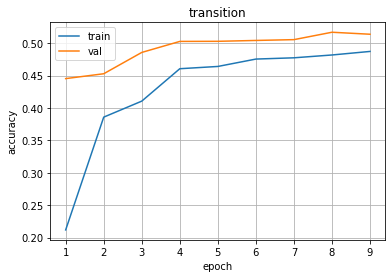

In [ ]:
#グラフを描画
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

epoch = ["1","2","3","4","5","6","7","8","9"]
#EpAc_train = [0.60, 0.65, 0.66, 0.70, 0.68]
#EpAc_val = [0.63, 0.67, 0.68, 0.72, 0.68]

plt.title("transition")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(epoch, EpAc_train, label = "train")
plt.plot(epoch, EpAc_val, label = "val")
plt.legend(loc = "upper left")
plt.grid(True)
plt.show()


In [ ]:
#自作テストデータで検証する場合
%%capture
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestData/動物
tedata="カワウソ.tsv"
dataset_train_eval, dataset_test = torchtext.data.TabularDataset.splits(path='.', train='/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestData/動物/damy.tsv', test=tedata, format='tsv', fields=[('content', TEXT), ('category', LABEL)])
dl_test = torchtext.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
batch = next(iter(dl_test))

In [ ]:
#提案手法
from tqdm import tqdm
import numpy as np
import pandas as pd
import csv
expected_coverage = [90,80,70,60,50]
text_data=[]
abstention_results = []
preds_all = np.array([],dtype=int)
TEX=[]
ABST=[]
LAB=[]
EXPORT=[]
SORT=[]
acc_cov=[]
abscount=0

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0
# for batch in tqdm(dl_test): 
for batch in dl_test:  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    inputs = batch.content[0].to(device)  # 文章
    labels = batch.category.to(device)  # ラベル
    #print(batch.content[0])

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):
        # BertForNicoに入力
      outputs = net_trained(inputs)
      values, predictions = torch.max(outputs, 1) 
      for j in range(len(predictions)):
        if predictions[j].cpu().numpy() == 6:
          abscount += 1
      
    #損失計算
      outputs = F.softmax(outputs,dim=1)
      outputs, reservation = outputs[:,:-1], outputs[:,-1] #[全行、最後以外全列],[全行、最後の列]

      abstention_results.extend(zip(list(reservation.cpu().numpy()),list(predictions.eq(labels.data).cpu().numpy()),list(inputs.data.cpu().numpy())))
      gain = torch.gather(outputs,dim=1,index=labels.unsqueeze(1)).squeeze()
      doubling_rate = (gain.add(reservation.div(reward))).log()

      loss = -doubling_rate.mean()
      preds_all = np.append(preds_all, predictions.cpu().numpy())
      epoch_corrects += torch.sum(predictions == labels.data)  # 正解数の合計を更新

#結果をファイル出力
df = pd.read_table(tedata,header=None)
for i in range(len(dl_test.dataset)):
  TEX.append(df.iloc[i,0])
  LAB.append(df.iloc[i,1])
  ABST.append(abstention_results[i][0])#棄却値をリストに格納
EXPORT.extend(zip(TEX,LAB,ABST))
#ソート
SORT = sorted(EXPORT, reverse=False, key=lambda x: x[2])
#出力
with open("result_n1.tsv", "w") as f:
  writer = csv.writer(f, lineterminator='\n',delimiter='\t')
  writer.writerows(SORT)

#棄却判定後の計算
#棄権の結果を予約の高低に応じて並べ替える(降順)
abstention_results.sort(key = lambda x: x[0], reverse=True)#リストの1列目の要素をキーに並び替える

# ソートされた結果の「正しいかどうか」のリストを取得する
#map(関数、加工元)…加工元データに関数をかけたものをリスト取得する
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))


#print("sorted_correct")
#print(sorted_correct)

size = len(dl_test.dataset)
i=0
print('accracy of coverage ',end='')
for coverage in expected_coverage:
  #print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*coverage/100):])),end='')
  print(coverage)
  count1=int(size*(100-coverage)/100) 
  count2=sum(sorted_correct[count1:])
  count3=size-count1 #カバレッジ考慮のデータ数
  acc_cov.append(count2/count3)
  
  print(acc_cov[i])
  i+=1
  #棄却されたテキストの表示
  #if coverage==90:
    #for j in range(count1):  
      #print(tokenizer.convert_ids_to_tokens(text_data[j]))

# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)
print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))

epoch_abs_acc=epoch_corrects.double() / (len(dl_test.dataset)-abscount)
print(abscount)
#print(preds_all)
print(epoch_abs_acc)

accracy of coverage 90
0.33447098976109213
80
0.3769230769230769
70
0.4298245614035088
60
0.5025641025641026
50
0.6012269938650306
テストデータ325個での正解率：0.3015
208
tensor(0.8376, device='cuda:0', dtype=torch.float64)


kokokara


In [59]:
print(cm_normalized)

[[0.01 0.04 0.04 0.   0.07 0.02 0.82]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


In [58]:
#実際の動画での検証
%%capture
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestData/字数無
ca=0
CTE="ゲーム(前無)"
tedata="g3.tsv"
dataset_train_eval, dataset_test = torchtext.data.TabularDataset.splits(path='.', train='/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestData/動物/damy.tsv', test=tedata, format='tsv', fields=[('content', TEXT), ('category', LABEL)])
dl_test = torchtext.data.Iterator(dataset_test, batch_size=batch_size, train=False, sort=False)
batch = next(iter(dl_test))

#提案手法
from tqdm import tqdm
import numpy as np
import pandas as pd

expected_coverage = [90,80,70,60,50]
text_data=[]
abstention_results = []
preds_all = np.array([],dtype=int)
TEX=[]
ABST=[]
LAB=[]
EXPORT=[]
SORT=[]
acc_cov=[]
abscount=0

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0
# for batch in tqdm(dl_test): 
for batch in dl_test:  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    inputs = batch.content[0].to(device)  # 文章
    labels = batch.category.to(device)  # ラベル
    #print(batch.content[0])

    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):
        # BertForNicoに入力
      outputs = net_trained(inputs)
      values, predictions = torch.max(outputs, 1) 
      for j in range(len(predictions)):
        if predictions[j].cpu().numpy() == 6:
          abscount += 1
      
    #損失計算
      outputs = F.softmax(outputs,dim=1)
      outputs, reservation = outputs[:,:-1], outputs[:,-1] #[全行、最後以外全列],[全行、最後の列]

      abstention_results.extend(zip(list(reservation.cpu().numpy()),list(predictions.eq(labels.data).cpu().numpy()),list(inputs.data.cpu().numpy())))
      gain = torch.gather(outputs,dim=1,index=labels.unsqueeze(1)).squeeze()
      doubling_rate = (gain.add(reservation.div(reward))).log()

      loss = -doubling_rate.mean()
      preds_all = np.append(preds_all, predictions.cpu().numpy())
      epoch_corrects += torch.sum(predictions == labels.data)  # 正解数の合計を更新

#結果をファイル出力
df = pd.read_table(tedata,header=None)
for i in range(len(dl_test.dataset)):
  TEX.append(df.iloc[i,0])
  LAB.append(df.iloc[i,1])
  ABST.append(abstention_results[i][0])#棄却値をリストに格納
EXPORT.extend(zip(TEX,LAB,ABST))
#ソート
SORT = sorted(EXPORT, reverse=False, key=lambda x: x[2])
#出力


#棄却判定後の計算
#棄権の結果を予約の高低に応じて並べ替える(降順)
abstention_results.sort(key = lambda x: x[0], reverse=True)#リストの1列目の要素をキーに並び替える

# ソートされた結果の「正しいかどうか」のリストを取得する
#map(関数、加工元)…加工元データに関数をかけたものをリスト取得する
sorted_correct = list(map(lambda x: int(x[1]), abstention_results))


#print("sorted_correct")
#print(sorted_correct)

size = len(dl_test.dataset)
i=0
print('accracy of coverage ',end='')
for coverage in expected_coverage:
  #print('{:.0f}: {:.3f}, '.format(coverage, sum(sorted_correct[int(size*coverage/100):])),end='')
  print(coverage)
  count1=int(size*(100-coverage)/100) 
  count2=sum(sorted_correct[count1:])
  count3=size-count1 #カバレッジ考慮のデータ数
  acc_cov.append(count2/count3)
  
  print(acc_cov[i])
  i+=1
  #棄却されたテキストの表示
  #if coverage==90:
    #for j in range(count1):  
      #print(tokenizer.convert_ids_to_tokens(text_data[j]))

# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)
print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))

epoch_abs_acc=epoch_corrects.double() / (len(dl_test.dataset)-abscount)
print(abscount)
#print(preds_all)
print(epoch_abs_acc)

#推論結果の出力
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import recall_score

df = pd.Cov = pd.read_csv(tedata, sep='\t',names=["content", "category", "predict"])
net_trained.eval()  #推論モードに

for index, row in df.iterrows():
    df.at[index, "predict"] = preds_all[index]  # GPU環境の場合は「.cpu().numpy()」としてください。

df.to_csv("predicted.tsv", sep='\t', index=False)
#混同行列の表示（評価）
from sklearn.metrics import confusion_matrix
import seaborn as sns

#有効数字
np.set_printoptions(precision=2)

y_true =[]
y_pred =[]
df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
for index, row in df.iterrows():
    if row['category'] == 0:
        y_true.append("POLITICS")
    if row['category'] ==1:
        y_true.append("COOK")
    if row['category'] ==2:
        y_true.append("ANIMAL")
    if row['category'] ==3:
        y_true.append("TRAIN")
    if row['category'] ==4:
        y_true.append("SPORT")
    if row['category'] ==5:
        y_true.append("GAME")    
    if row['category'] ==6:
        y_true.append("ABSTENTION")     
    if row['predict'] ==0.0:
        y_pred.append("POLITICS")
    if row['predict'] ==1.0:
        y_pred.append("COOK")
    if row['predict'] ==2.0:
        y_pred.append("ANIMAL")
    if row['predict'] ==3.0:
        y_pred.append("TRAIN")
    if row['predict'] ==4.0:
        y_pred.append("SPORT")
    if row['predict'] ==5.0:
        y_pred.append("GAME")
    if row['predict'] ==6.0:
        y_pred.append("ABSTENTION")


print(len(y_true))
print(len(y_pred))


# 混同行列(confusion matrix)の取得
labels = ["POLITICS", "COOK", "ANIMAL","TRAIN","SPORT","GAME","ABSTENTION"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # データフレームに変換
# cm_labeled = pd.DataFrame(cm_normalized, columns=labels, index=labels)

# # 結果の表示
# #cm_labeled
# plt.figure(figsize=(15, 15))
# sns.set(font_scale=2.5,font="Times New Roman") 
# sns.set_style("darkgrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
# sns.heatmap(cm_labeled,annot=True,cmap='Blues', fmt="1.2f",square=True)
# plt.xlabel('Predicted Label', fontsize = 35) # x-axis label with fontsize 15
# plt.ylabel('True Label', fontsize = 35) # y-axis label with fontsize 15

# plt.show()

print(cm_normalized)
#tsvに出力

with open("/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/realvideo.tsv","a") as f:
  writer = csv.writer(f,delimiter='\t')
  
  writer.writerow([CTE,tedata,len(dl_test.dataset),abscount,epoch_abs_acc.cpu().numpy(),cm_normalized[ca][0],cm_normalized[ca][1],cm_normalized[ca][2],cm_normalized[ca][3],cm_normalized[ca][4],cm_normalized[ca][5],cm_normalized[ca][6]])




kokomade


In [ ]:
#推論結果の出力
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score

df = pd.Cov = pd.read_csv(tedata, sep='\t',names=["content", "category", "predict"])
net_trained.eval()  #推論モードに

for index, row in df.iterrows():
    df.at[index, "predict"] = preds_all[index]  # GPU環境の場合は「.cpu().numpy()」としてください。

df.to_csv("predicted.tsv", sep='\t', index=False)
#混同行列の表示（評価）
from sklearn.metrics import confusion_matrix
import seaborn as sns

#有効数字
np.set_printoptions(precision=2)

y_true =[]
y_pred =[]
df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
for index, row in df.iterrows():
    if row['category'] == 0:
        y_true.append("POLITICS")
    if row['category'] ==1:
        y_true.append("COOK")
    if row['category'] ==2:
        y_true.append("ANIMAL")
    if row['category'] ==3:
        y_true.append("TRAIN")
    if row['category'] ==4:
        y_true.append("SPORT")
    if row['category'] ==5:
        y_true.append("GAME")    
    if row['category'] ==6:
        y_true.append("ABSTENTION")     
    if row['predict'] ==0.0:
        y_pred.append("POLITICS")
    if row['predict'] ==1.0:
        y_pred.append("COOK")
    if row['predict'] ==2.0:
        y_pred.append("ANIMAL")
    if row['predict'] ==3.0:
        y_pred.append("TRAIN")
    if row['predict'] ==4.0:
        y_pred.append("SPORT")
    if row['predict'] ==5.0:
        y_pred.append("GAME")
    if row['predict'] ==6.0:
        y_pred.append("ABSTENTION")


print(len(y_true))
print(len(y_pred))


# 混同行列(confusion matrix)の取得
labels = ["POLITICS", "COOK", "ANIMAL","TRAIN","SPORT","GAME","ABSTENTION"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# データフレームに変換
cm_labeled = pd.DataFrame(cm_normalized, columns=labels, index=labels)

# 結果の表示
#cm_labeled
plt.figure(figsize=(15, 15))
sns.set(font_scale=2.5,font="Times New Roman") 
sns.set_style("darkgrid", {'font.family':'serif', 'font.serif':'Times New Roman'})
sns.heatmap(cm_labeled,annot=True,cmap='Blues', fmt="1.2f",square=True)
plt.xlabel('Predicted Label', fontsize = 35) # x-axis label with fontsize 15
plt.ylabel('True Label', fontsize = 35) # y-axis label with fontsize 15

plt.show()


931
931
[[0.89 0.01 0.01 0.01 0.02 0.   0.07]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
#各種推論計算結果の表示
y_true =[]
y_pred =[]

df = pd.read_csv("predicted.tsv", sep='\t', engine="python", encoding="utf-8")
for index, row in df.iterrows():
    y_true.append(row["category"])
    y_pred.append(row["predict"])

_pred = [
    round(float(val)) for val in y_pred
]



ALL=5000#全データ数




TG_ALL=0#対象カテゴリ全データ数
TG_ABS=0#対象カテゴリの棄権データ数
PR_ALL=0#対象カテゴリを推測したデータ数
TP=0#対象カテゴリの推測が正解したデータ数

#ラベル0 : 対象カテゴリクラス
#ラベル2 : 棄権クラス
for i in range(len(y_true)):
  if y_true[i]==0:
    TG_ALL+=1
  if y_pred[i]==6 and y_true[i]==0:
    TG_ABS+=1
  if y_pred[i]==0 and y_true[i]==0:
    TP+=1
  if y_pred[i]==0 :
    PR_ALL+=1

RECALL=TP/(TG_ALL-TG_ABS)
PRECISION=TP/PR_ALL
F1=2*RECALL*PRECISION/(RECALL+PRECISION)



print("棄却数：{}".format(abscount))
absdiv=len(dl_test.dataset)-abscount
ACCURACY=epoch_corrects.double() /absdiv
print("Accuracy(正解率)：{}".format(ACCURACY))   

print("Recall(再現率)：{}".format(RECALL))
print("Precision(適合率)：{}".format(PRECISION))
print("F1score：{}".format(F1))

棄却数：8074
Accuracy(正解率)：0.7597458850707479
Recall(再現率)：0.8329637841832964
Precision(適合率)：0.8119596541786743
F1score：0.8223276176577893


In [ ]:
#tsvに出力
import csv
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid
with open("/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestResult.tsv","a") as f:
  writer = csv.writer(f,delimiter='\t')
  
  writer.writerow([CTE,trdata,reward,num_epochs,EpAc_train[-1].cpu().numpy(),EpAc_val[-1].cpu().numpy(),abscount,ACCURACY.cpu().numpy(),RECALL,PRECISION,F1,epoch_acc.cpu().numpy(),acc_cov[0],acc_cov[1],acc_cov[2],acc_cov[3],acc_cov[4]])

## **描画**

In [ ]:
#棄却考慮した新たなデータセット作成
df = pd.read_csv("predicted_n.tsv",  sep='\t',engine="python", encoding="utf-8")

df_org = df.copy()

# for index, row in df.iterrows():
#   df_org.drop(row['predict']=6.0, inplace=True)
df_org=df[df.predict != 6.0]
df2=df_org.drop('predict', axis=1)

df2.to_csv("tr_n.tsv", sep='\t', index=False)

In [ ]:
#グラフを描画
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import rcParams

# epoch = ["1", "2", "3","4","5","6","7","8","9"]
# #EpAc_train = [0.60, 0.65, 0.66, 0.70, 0.68]
# #EpAc_val = [0.63, 0.67, 0.68, 0.72, 0.68]

# plt.title("transition")
# plt.xlabel("epoch")
# plt.ylabel("accuracy")
# plt.plot(epoch, EpAc_train, label = "train")
# plt.plot(epoch, EpAc_val, label = "val")
# plt.legend(loc = "upper left")
# plt.grid(True)
# plt.show()


In [ ]:
print(EpAc_train)
print(EpAc_val)

[tensor(0.1622, device='cuda:0', dtype=torch.float64), tensor(0.3888, device='cuda:0', dtype=torch.float64), tensor(0.4067, device='cuda:0', dtype=torch.float64), tensor(0.4566, device='cuda:0', dtype=torch.float64), tensor(0.4606, device='cuda:0', dtype=torch.float64), tensor(0.4714, device='cuda:0', dtype=torch.float64), tensor(0.4758, device='cuda:0', dtype=torch.float64), tensor(0.4845, device='cuda:0', dtype=torch.float64), tensor(0.4848, device='cuda:0', dtype=torch.float64)]
[tensor(0.4171, device='cuda:0', dtype=torch.float64), tensor(0.4488, device='cuda:0', dtype=torch.float64), tensor(0.4434, device='cuda:0', dtype=torch.float64), tensor(0.4748, device='cuda:0', dtype=torch.float64), tensor(0.4890, device='cuda:0', dtype=torch.float64), tensor(0.4884, device='cuda:0', dtype=torch.float64), tensor(0.5061, device='cuda:0', dtype=torch.float64), tensor(0.4927, device='cuda:0', dtype=torch.float64), tensor(0.5106, device='cuda:0', dtype=torch.float64)]


In [7]:
# # #保存済みモデルを使う場合
%cd /content/drive/MyDrive/Google Colab/niconico_dataset_add_smid
net_trained.load_state_dict(torch.load("model_bert5.7_all.pth"))

/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid


<All keys matched successfully>

## **テスト**

In [ ]:
#棄却度順に文章表示
#for j in range(count1):  
 # print(tokenizer.convert_ids_to_tokens(text_data[j]))

In [ ]:
# #ABS考慮した評価指標
# print(y_true)
# print(y_pred)
# y_pred = [
#     round(float(val)) for val in y_pred
# ]

# TP=0

# ALL=5000
# TG_ALL=0
# TG_ABS=0
# PR_ALL=0

# for i in range(len(y_true)):
#   if y_true[i]==0:
#     TG_ALL+=1
#   if y_pred[i]==2 and y_true[i]==0:
#     TG_ABS+=1
#   if y_pred[i]==0 and y_true[i]==0:
#     TP+=1
#   if y_pred[i]==0 :
#     PR_ALL+=1

# RECALL=TP/(TG_ALL-TG_ABS)
# PRECISION=TP/PR_ALL

# print("Recall(再現率)：{}".format(RECALL))
# #print(TP/(TG_ALL-TG_ABS))
# print("Precision(適合率)：{}".format(PRECISION))
# #print(TP/PR_ALL)
# print("F1score：")
# print(2*RECALL*PRECISION/(RECALL+PRECISION))


In [ ]:
#推論結果の出力
# %cd /content/drive/My Drive/Google Colab/niconico_dataset_add_smid
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.metrics import f1_score
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# df = pd.Cov = pd.read_csv(tedata, sep='\t',names=["content", "category", "predict"])
# net_trained.eval()  #推論モードに

# for index, row in df.iterrows():
#     df.at[index, "predict"] = preds_all[index]  # GPU環境の場合は「.cpu().numpy()」としてください。

# df.to_csv("predicted.tsv", sep='\t', index=False)
# #混同行列の表示（評価）
# from sklearn.metrics import confusion_matrix
# import seaborn as sns

# y_true =[]
# y_pred =[]
# df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
# for index, row in df.iterrows():
#     if row['category'] == 0:
#         y_true.append("POLITICS")
#     if row['category'] ==1:
#         y_true.append("COOKING")
#     if row['category'] ==2:
#         y_true.append("ANIMAL")
#     if row['category'] ==3:
#         y_true.append("ABSTENTION")
#     if row['predict'] ==0.0:
#         y_pred.append("POLITICS")
#     if row['predict'] ==1.0:
#         y_pred.append("COOKING")
#     if row['predict'] ==2.0:
#         y_pred.append("ANIMAL")
#     if row['predict'] ==3.0:
#         y_pred.append("ABSTENTION")

# print(len(y_true))
# print(len(y_pred))

# # 混同行列(confusion matrix)の取得
# labels = ["POLITICS", "COOKING", "ANIMAL", "ABSTENTION"]
# cm = confusion_matrix(y_true, y_pred, labels=labels)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # データフレームに変換
# cm_labeled = pd.DataFrame(cm_normalized, columns=labels, index=labels)

# # 結果の表示
# #cm_labeled
# sns.set(font_scale=0.7) 
# sns.heatmap(cm_labeled,annot=True,cmap='Blues',fmt='.2g',square=True)
# plt.xlabel('Predicted Label', fontsize = 9) # x-axis label with fontsize 15
# plt.ylabel('True Label', fontsize = 9) # y-axis label with fontsize 15

# plt.show()


In [ ]:
# #混同分布からテキスト表示（政治）
# s_c =[]
# s_p =[]
# s_ab =[]
# df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
# for index, row in df.iterrows():
#     if row['category'] == 0 and row['predict'] == 1:
#         s_c.append(row['content'])
#     if row['category'] == 0 and row['predict'] == 2:
#         s_p.append(row['content'])
#     if row['category'] == 0 and row['predict'] == 3:   
#         s_ab.append(row['content'])   

# with open('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestDate/text/安倍.txt', 'w') as f:
#     f.write("[政治/料理]################################################################\n")
#     for d in s_c:
#         f.write("%s\n" % d)
#     f.write("\n\n[政治/動物]############################################################\n")
#     for d in s_p:
#         f.write("%s\n" % d)
#     f.write("\n\n[政治/棄却]############################################################\n")
#     for d in s_ab:
#         f.write("%s\n" % d)                

In [ ]:
# #混同分布からテキスト表示（料理）
# s_c =[]
# s_p =[]
# s_ab =[]
# df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
# for index, row in df.iterrows():
#     if row['category'] == 1 and row['predict'] == 0:
#         s_c.append(row['content'])
#     if row['category'] == 1 and row['predict'] == 2:
#         s_p.append(row['content'])
#     if row['category'] == 1 and row['predict'] == 3:   
#         s_ab.append(row['content'])   

# with open('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestDate/text/菜の花.txt', 'w') as f:
#     f.write("[料理/政治]###############################################################################\n")
#     for d in s_c:
#         f.write("%s\n" % d)
#     f.write("\n\n[料理/動物]###############################################################################\n")
#     for d in s_p:
#         f.write("%s\n" % d)
#     f.write("\n\n[料理/棄却]###############################################################################\n")
#     for d in s_ab:
#         f.write("%s\n" % d)                

In [ ]:
# #混同分布からテキスト表示（動物）
# s_c =[]
# s_p =[]
# s_ab =[]
# df = pd.read_csv("predicted.tsv",  sep='\t',engine="python", encoding="utf-8")
# for index, row in df.iterrows():
#     if row['category'] == 2 and row['predict'] == 0:
#         s_c.append(row['content'])
#     if row['category'] == 2 and row['predict'] == 1:
#         s_p.append(row['content'])
#     if row['category'] == 2 and row['predict'] == 3:   
#         s_ab.append(row['content'])   

# with open('/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestDate/text/犬食べた.txt', 'w') as f:
#     f.write("[動物/政治]###############################################################################\n")
#     for d in s_c:
#         f.write("%s\n" % d)
#     f.write("\n\n[動物/料理]###############################################################################\n")
#     for d in s_p:
#         f.write("%s\n" % d)
#     f.write("\n\n[動物/棄却]###############################################################################\n")
#     for d in s_ab:
#         f.write("%s\n" % d)                

## **訓練データ作成**

In [ ]:
# #テスト分割無し訓練データの生成
# import pandas as pd
# import glob

# path = "/content/drive/My Drive/Google Colab/niconico_dataset_add_smid/実験" # use your path
# all_files = glob.glob(path + "/*.csv")#csv
# list_dataset = []
 
# for filename in all_files:
#     df2 = pd.read_csv(filename)#csv
#     list_dataset.append(df2)
 
# df = pd.concat(list_dataset, axis=0, ignore_index=True)
# df = df.sample(frac=1, random_state=45).reset_index(drop=True)

# # 分割してtsvファイルで保存する
# df.to_csv("/content/drive/MyDrive/Google Colab/niconico_dataset_add_smid/TestDate/TRAIN.tsv", sep='\t', index=False, header=None)
# print(df.shape)